# Instructions


In [ ]:
'''

# General Remarks

Your assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. 

1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment
2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.
3. You are allowed to use whatever optimization algorithm you think is most efficient.
4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.
5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). 
6. You will as well report the Area Under the Curve (AUC) of your classifier on the test dataset.


# Specific Tasks
1. How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?
2. How does the accuracy depend on the resolution of the input image?
3. Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?
4. What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..
5. Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).


# Last Remark
A. Your code needs to be readable and **reproducible**. Make sure that it is possible to run the notebook to reproduce all the results presented in the pdf report. 
B. You need to submit two files: (1) a jupyter notebook with your code (2) a pdf report explaining your approaches and conclusions.  
C. Your report pdf report does not need to be long. It needs to describe the experiments that you have carried out, briefly detail the algorithms that you have used, include a few figures and outline the conclusions of your investigations. You can have a look at these (very good) machine-learning papers available [here](https://nips.cc/Conferences/2021/DatasetsBenchmarks/AcceptedPapers) although (indeed!) your report definitely does not need to be as long as these articles.  
D. You need to acknowledge carefully all the sources that you have used. 

'''

'\n\n# General Remarks\n\nYour assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. \n\n1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment\n2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.\n3. You are allowed to use whatever optimization algorithm you think is most efficient.\n4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.\n5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). \n6. You will as we

Group Number: 44

Filename: assignment_1_44.ipynb 

Group Member 1: Beh Ruey Yan, A0236004W 

Group Member 2: Shan Shenghao, A0116327L

Group Member 3: Wu Qiming, A0236022W 

Group Member 4: Qisheng Hu, A0235960B

# First time setup
#### Place "img_celeba_small.zip" under "/content/drive/MyDrive/datasets/celeba"
#### Place "celeba.csv" under "/content/drive/MyDrive/datasets/"
#### Run below to unzip

In [ ]:
# start from fresh and unmount any drive that was mounted before
# sometimes take a bit of time
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")
# let's unzip the data (takes a bit of time, be patient) in the same directory
# It takes a few minutes (but only needs to be done once) -- roughly unzip 100 files per seconds
!unzip /content/drive/MyDrive/datasets/celeba/img_celeba_small.zip  -d  /content/drive/MyDrive/datasets/celeba

# Load Celeba images on a Google Colab


In [ ]:
# start from fresh and unmount any drive that was mounted before
# sometimes take a bit of time
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install optax

In [ ]:
import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import optax
import jax.numpy as jnp
from sklearn import metrics
from tqdm.notebook import tqdm_notebook
from PIL import Image, ImageEnhance
import seaborn as sns
np.random.seed(42)
from jax import random
key = random.PRNGKey(42)

In [ ]:
#let us list all the files in the image directory
path = "/content/drive/MyDrive/datasets/celeba/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

Number of images: 20000


**Loading Datasets**

In [ ]:
#load attributes csv file
path_csv  = "/content/drive/MyDrive/datasets/"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))

In [ ]:
#let us keep only the relevant attributes
attribute = attribute[:20000]
label = attribute["Male"]

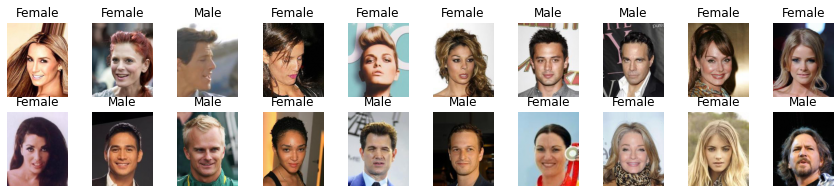

In [ ]:
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100 for display (you do not have to do this in the assignment)
    #im = resize(im, (100,100) ) # 218, 178, 3
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
   

**1.1 Creating training and validation datasets**

In [ ]:
y_train = np.array(label[:15000])
y_test = np.array(label[15000:20000])
#img_train=np.array([imageio.imread(os.path.join(path, all_img[k])).astype(float) for k in range(5000)])
#img_test=np.array([imageio.imread(os.path.join(path, all_img[k])).astype(float) for k in range(15000,20000)])
# subset training set by male/old
y_train_m = y_train[y_train == 1] 
y_train_f = y_train[y_train == -1]

print("Proportion of male in dataset: {0:.3f}".format(len(y_train_m)/len(y_train)))

Proportion of male in dataset: 0.422


In [ ]:
# adjust contrast of images
def adjust_contrast(im, size=(100, 100, 3), factor=1.5):
  new_im = (im * 255).astype(np.uint8)
  new_im = Image.fromarray(new_im.reshape(size), 'RGB')
  enhancer = ImageEnhance.Contrast(new_im)
  new_im = enhancer.enhance(factor)
  return np.array(new_im)

In [ ]:
#load the training/testing images
def load_image(img_idx, resize_shape, is_color, contrast_adjust, cropping):
  img = []
  for i in tqdm_notebook(img_idx):
    im = imageio.imread(os.path.join(path, all_img[i])).astype(float)

    # resize
    im = resize(im, resize_shape)

    # adjust contrast
    if contrast_adjust:
      im = adjust_contrast(im)

    # cropping
    if cropping is not None:
      top,bottom,left,right = cropping
      im = im[top:bottom,left:right,:]
    
    # reshape
    if is_color and cropping is None:
      im = im.reshape(resize_shape[0]*resize_shape[1]*3)
    elif is_color and cropping is not None:
      im = im.reshape((bottom-top)*(right-left)*3)
    elif (not is_color) and cropping is None:
      im = np.mean(im, axis=2)
      im = im.reshape(resize_shape[0]*resize_shape[1])
    else:
      im = np.mean(im, axis=2)
      im = im.reshape((bottom-top)*(right-left))

    img.append(im)

  img = np.array(img, dtype="float") / 255.0
  
  return img

In [ ]:
#get img_train, img_test, y_train, y_test
def get_data(train_indices, test_indices, reshape_size=(218,178), is_color=True, contrast_adjust=False, cropping=None):
  img_train = load_image(train_indices,reshape_size,is_color,contrast_adjust,cropping)
  img_test = load_image(test_indices,reshape_size,is_color,contrast_adjust,cropping)
  y_train = np.array(label[train_indices])
  y_test = np.array(label[test_indices])
  return img_train, img_test, y_train, y_test

In [ ]:
img_train, img_test, y_train, y_test = get_data(np.arange(5000), np.arange(15000, 20000), (100,100), True, False, None)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

**1.2 Define prediction and loss function**

$$P(Y=1|x) = \frac{1}{1 + \exp[-\langle x, \beta\rangle]}$$

$$\frac{1}{N}\sum_{i=1}^N \log[1 + \exp(-y_i \, \langle x_i, \beta \rangle)]$$

In [ ]:
def prediction(beta, x):
    """
    desc:
    =====
    compute the probability that x is associated to a +1 label

    args:
    ====
     x: vector of dimension 784
     beta: vector of dimension 784 (logistic reg param)     
    """
    proba = 1. / (1. + jnp.exp(-jnp.dot(x,beta)))
    return proba


# let us parallelize the function:
# beta: no parallelization
# x: parallelization along the axis 0
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))

# let us now define a function tat can compute the error rate

@jax.jit
def compute_accuracy(beta, X, Y):
    # compute predictions
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return jnp.mean(Y == pred)

@jax.jit
def loss_single(beta, x, y):
    """
    desc:
    =====
    compute the loss for a single image

    args:
    ====
     beta: vector of dimension 784 (logistic reg param)
     x: vector of dimension 784
     y: {+1, -1} label
    """
    return jnp.log(1. + jnp.exp(-y * jnp.dot(x,beta)))

# loss_single(beta, x, y)
# beta: do not parallelize
# x: parallelize along the axis 0
# y: parallelize along the axis 0
loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))

@jax.jit
def loss(beta, X, Y):
    """
    desc:
    ====
     logistic regression loss
    """
    # compute all the individual losses
    loss_individuals = loss_all(beta, X, Y)
    
    # return the average loss
    return jnp.mean(loss_individuals)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

def ROC(beta, x, y):
    y_pred_proba = prediction_batch(beta,x)
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    return fpr,tpr,auc

In [ ]:
# Initialise beta
D = 100*100*3
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)

**Gradient Descent**

In [ ]:
n_iter = 500
loss_history = []
learning_rate = 0.001
beta = np.copy(beta_init)

for k in range(n_iter):
    v,g = loss_value_and_grad(beta, img_train, y_train)
    
    beta = beta - learning_rate * g
    loss_history.append(v)
    
    if k % 50 == 0:
        # let us compute the train/validation error rate
        err_train = 100 * compute_accuracy(beta, img_train, y_train)
        err_val = 100 * compute_accuracy(beta, img_test, y_test)        
        print(f"iter:{k} \t Loss:{v:2.3f} \t accuracy(train):{err_train:2.1f}% \t accuracy(val):{err_val:2.1f}%")
#ROC(beta,img_test, y_test)        

iter:0 	 Loss:0.697 	 accuracy(train):58.7% 	 accuracy(val):58.1%
iter:50 	 Loss:0.586 	 accuracy(train):68.6% 	 accuracy(val):68.4%
iter:100 	 Loss:0.551 	 accuracy(train):72.3% 	 accuracy(val):71.9%
iter:150 	 Loss:0.528 	 accuracy(train):74.3% 	 accuracy(val):74.3%
iter:200 	 Loss:0.510 	 accuracy(train):75.9% 	 accuracy(val):75.5%
iter:250 	 Loss:0.496 	 accuracy(train):77.2% 	 accuracy(val):76.6%
iter:300 	 Loss:0.484 	 accuracy(train):78.1% 	 accuracy(val):77.8%
iter:350 	 Loss:0.473 	 accuracy(train):79.1% 	 accuracy(val):78.5%
iter:400 	 Loss:0.464 	 accuracy(train):79.8% 	 accuracy(val):79.1%
iter:450 	 Loss:0.455 	 accuracy(train):80.4% 	 accuracy(val):79.7%


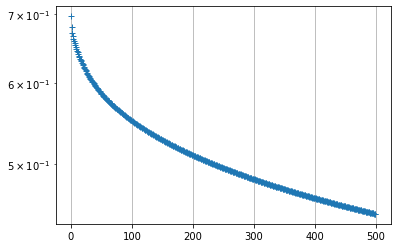

In [ ]:
plt.plot(loss_history, "+")
plt.yscale("log")
plt.grid(True)

In [ ]:
def plot_loss_ROC_0(fpr,tpr,auc,accuracy):
  plt.plot(fpr,tpr)
  plt.text(0.1,0,"AUC="+"{0:.2f}".format(auc)+"; Acurracy="+"{0:.2f}%".format(accuracy),size=16)
  plt.title("ROC")
  plt.show()

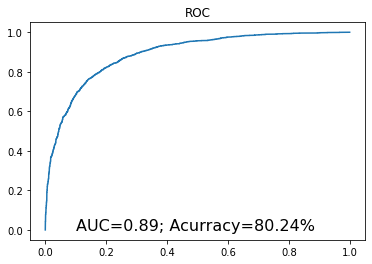

In [ ]:
fpr,tpr,auc =ROC(beta, img_train, y_train)
accuracy = 100 * compute_accuracy(beta, img_test, y_test)  
plot_loss_ROC_0(fpr, tpr, auc, accuracy)

**SGD**

In [ ]:
def run_SGD(minibatch_size, X, Y, X_test, Y_test,beta_init, n_epoch):
    N = len(X)  #10000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    beta = np.copy(beta_init)
    learning_rate = 0.001

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X[batch_indices]
            Y_minibatch = Y[batch_indices]

            # compute the stochastic gradient
            val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            all_loss_within_epoch.append(val)
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        #if (epoch+1)% 5 == 0:
         # err_train = 100*compute_accuracy(beta, X,Y)
          #err_val= 100*compute_accuracy(beta, X_test, Y_test)        
          #print(f"epoch:{epoch+1} \t Loss:{loss_epoch:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    return beta, loss_history_end_epoch

def evaluate(beta, loss_history_end_epoch, X_test, Y_test):
    accuracy = 100 * compute_accuracy(beta, X_test, Y_test)  
    fpr,tpr,auc = ROC(beta,X_test, Y_test)
    plot_loss_ROC(loss_history_end_epoch, fpr, tpr, auc, accuracy)    
    return fpr, tpr, auc, accuracy

def plot_loss_ROC(loss_history_end_epoch,fpr,tpr,auc,accuracy):
  plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.plot(loss_history_end_epoch, "-^")
  plt.title("Loss")
  plt.yscale("log")
  plt.xlabel("Epochs")
  plt.grid(True)

  plt.subplot(1, 2, 2) # index 2
  plt.plot(fpr,tpr)
  plt.text(0.1,0,"AUC="+"{0:.2f}".format(auc)+"; Acurracy="+"{0:.2f}%".format(accuracy),size=16)
  plt.title("ROC")

  plt.show()

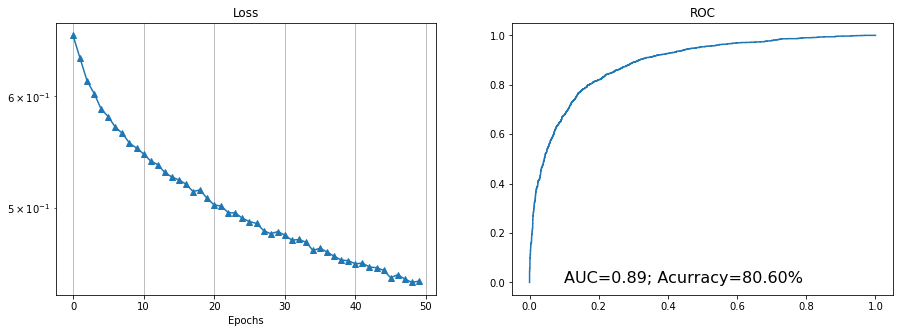

In [ ]:
minibatch = 500
n_epoch = 50
beta,loss_history_end_epoch = run_SGD(minibatch, img_train, y_train, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

**Different Optimizers**

In [ ]:

def run_Optimizer(minibatch_size, X, Y, X_test, Y_test, beta_init, n_epoch, optimizer):
    N = len(X)  #10000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    learning_rate = 0.001

    beta = np.copy(beta_init)
    # params = {'beta': np.copy(beta_init)}
    
    opt_state = optimizer.init(beta)
    compute_loss = lambda params, x, y: loss(beta, x, y)

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X[batch_indices]
            Y_minibatch = Y[batch_indices]
            val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)
            # val = loss(params['beta'], X_minibatch, Y_minibatch)
            # grads = jax.grad(compute_loss)(params, X_minibatch, Y_minibatch)
            # opt_state = optimizer.update(beta, opt_state)
            opt_state = optimizer.update(grad, opt_state)
            # beta = optimizer.get_params(opt_state)
            beta = optimizer.get_params(opt_state)

            # book-keeping
            all_loss_within_epoch.append(val)
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        #if (epoch+1)% 5 == 0:
         # err_train = 100*compute_accuracy(beta, X,Y)
          #err_val= 100*compute_accuracy(beta, X_test, Y_test)        
          #print(f"epoch:{epoch+1} \t Loss:{loss_epoch:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    return beta, loss_history_end_epoch

Momentum:
$$v_t = -η \nabla J(\theta_t) + αv_{t-1}$$
$$\theta_{t+1} = \theta{t} + v_t$$

Adam:
$$\theta_t = \theta_{t-1} - η* \frac{\hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon}$$
$$\hat{m_t}=\frac{m_t}{1-\beta_1^t}$$
$$\hat{v_t}=\frac{v_t}{1-\beta_2^t}$$

In [ ]:

class sgd():
  def __init__(self, step_size) -> None:
      self.step_size = step_size
  
  def init(self, x):
    return x
  
  def update(self, g, state):
    state = state - self.step_size * g
    return state
  
  def get_params(self, state):
    return state


class momentum():
  def __init__(self, step_size, mass: float) -> None:
      self.step_size = step_size
      self.mass = mass
  
  # initialize input
  def init(self, x):
    v = jnp.zeros_like(x)
    return x, v
  
  def update(self, g, state):
    x, velocity = state
    # calculate momentum & velocity
    velocity = self.mass * velocity + g 
    x = x - self.step_size * velocity
    return x, velocity
  
  def get_params(self, state):
    x, _ = state
    return x


class adam():
  def __init__(self, step_size, b1=0.9, b2=0.999, eps=1e-8) -> None:
      self.step_size = step_size
      self.b1=b1
      self.b2=b2
      self.eps=eps
      self.i = 0
  
  # initialize input
  def init(self, x):
    m = jnp.zeros_like(x)
    v = jnp.zeros_like(x)
    return x, m, v
  
  def update(self, g, state):
    self.i = self.i + 1
    x, m, v = state
    # First moment estimate and bias correction
    m = (1 - self.b1) * g + self.b1 * m  
    mhat = m / (1 - jnp.asarray(self.b1, m.dtype) ** (self.i + 1)) 
    # Second moment estimate and bias correction
    v = (1 - self.b2) * jnp.square(g) + self.b2 * v
    vhat = v / (1 - jnp.asarray(self.b2, m.dtype) ** (self.i + 1))
    x = x - self.step_size * mhat / (jnp.sqrt(vhat) + self.eps)
    return x, m, v
  
  def get_params(self, state):
    x, _, _ = state
    return x



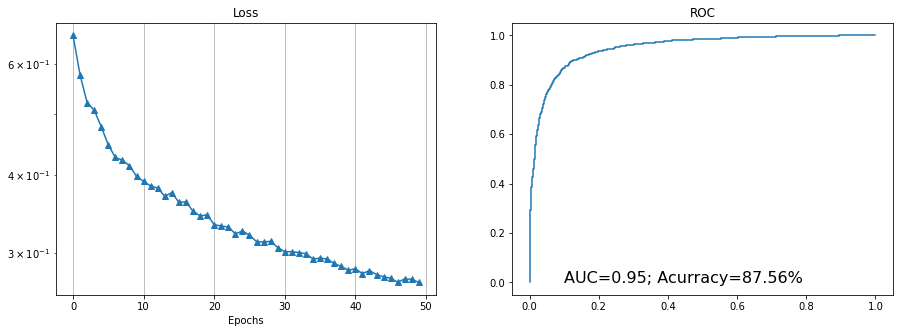

In [ ]:
# Momentum
minibatch = 500
n_epoch = 50
op_momentum = momentum(step_size = 1e-3, mass = 0.9)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train, y_train, img_test, y_test, beta_init, n_epoch, op_momentum)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

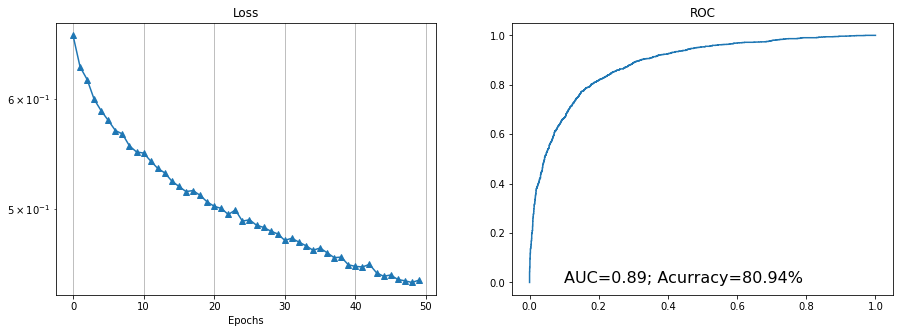

In [ ]:
# SGD
minibatch = 500
n_epoch = 50
op_adam = sgd(step_size = 1e-3)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train, y_train, img_test, y_test, beta_init, n_epoch, op_adam)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

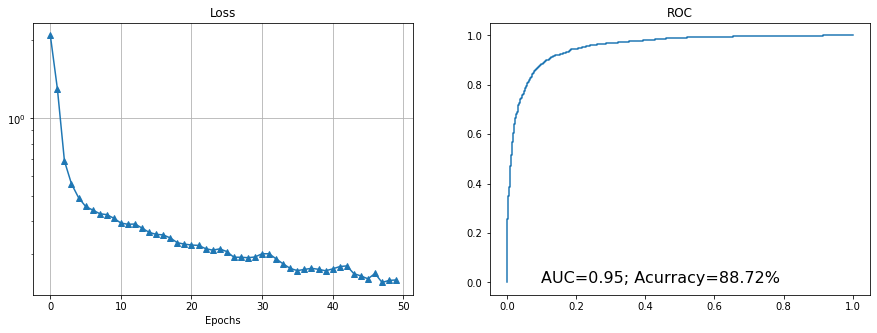

In [ ]:
# Adam
minibatch = 500
n_epoch = 50
op_adam = adam(step_size = 1e-3)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train, y_train, img_test, y_test, beta_init, n_epoch, op_adam)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

### Task 1. Size of training dataset

--------------Size of training dataset (Number of images):500--------------


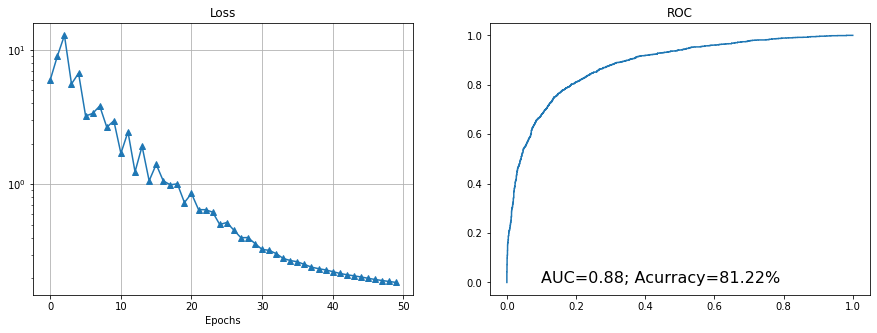

--------------Size of training dataset (Number of images):1000--------------


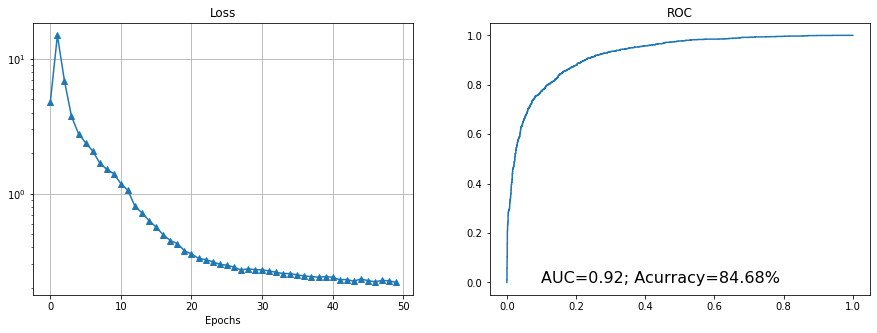

--------------Size of training dataset (Number of images):2000--------------


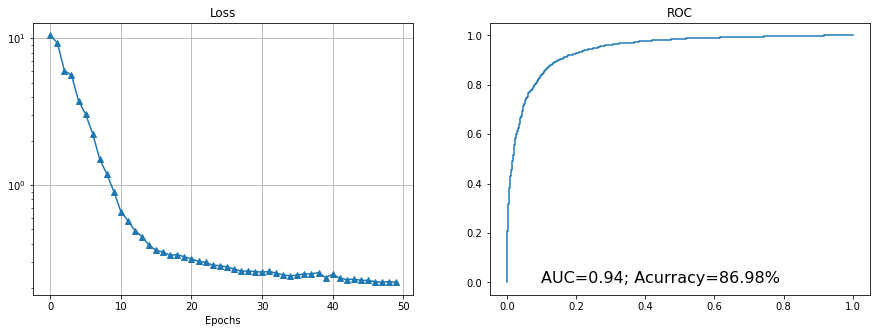

--------------Size of training dataset (Number of images):3500--------------


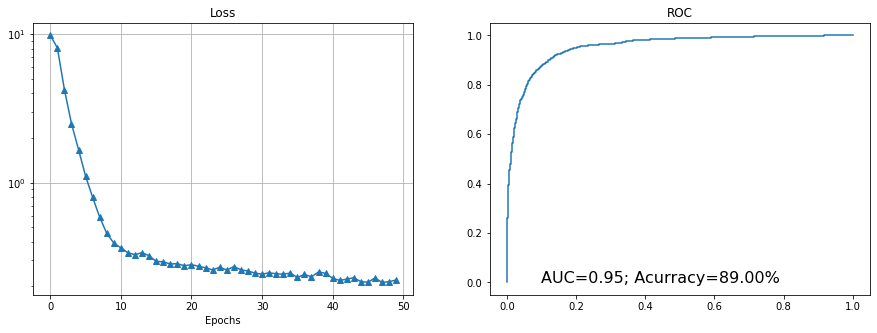

--------------Size of training dataset (Number of images):5000--------------


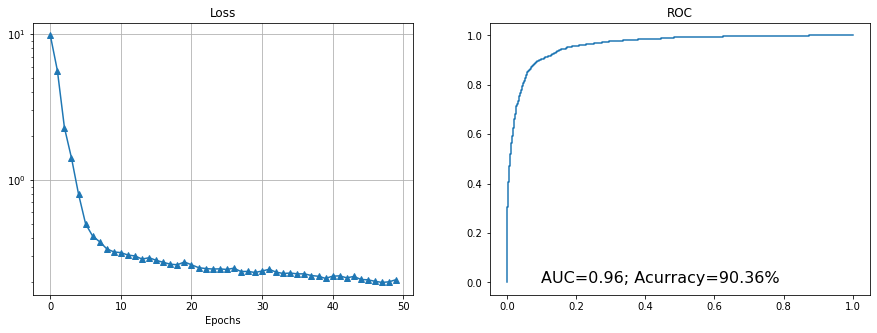

In [ ]:
training_data_size = [500, 1000, 2000, 3500, 5000] 
for i in training_data_size:
  img_train_size = img_train[:i]
  y_train_size = np.array(y_train[:i])
  print(f"--------------Size of training dataset (Number of images):{i}--------------")
  beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_size, y_train_size, img_test, y_test, beta_init, n_epoch, op_adam)
  #beta, loss_history_end_epoch = run_SGD(minibatch, img_train_size, y_train_size, img_test, y_test, beta_init, n_epoch)
  fpr,tpr,auc,accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)
img_train_size,y_train_size=[],[] # reduce Disk/RAM usage

__TODO__: How does test accuracy change with size of training set?

### Task 2. Image resolution

--------------Image Resolution: 30 * 30--------------


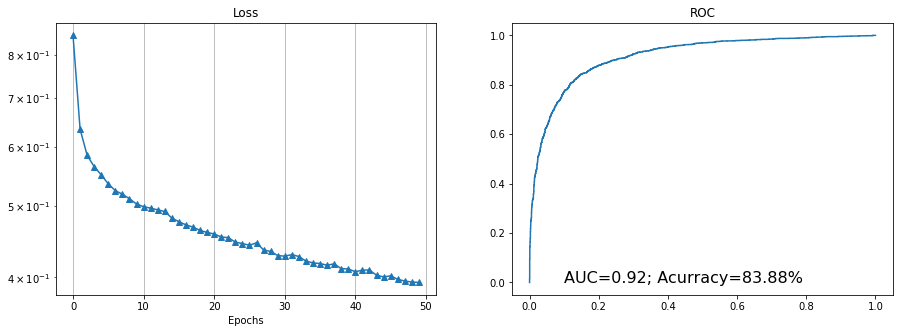

--------------Image Resolution: 50 * 50--------------


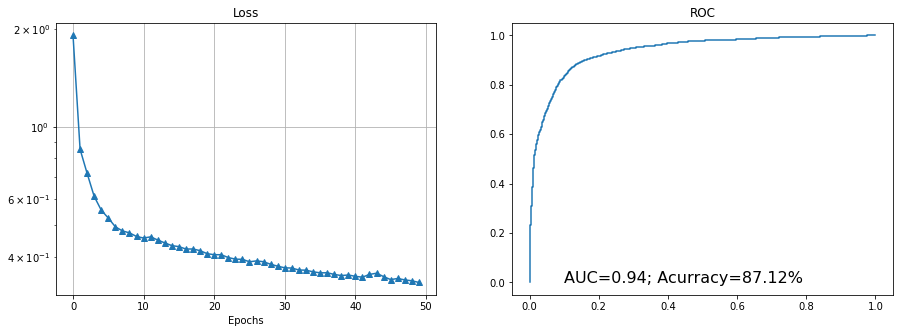

--------------Image Resolution: 70 * 70--------------


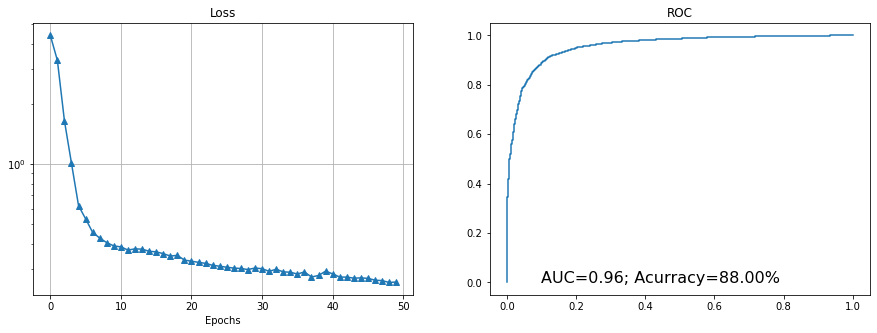

--------------Image Resolution: 100 * 100--------------


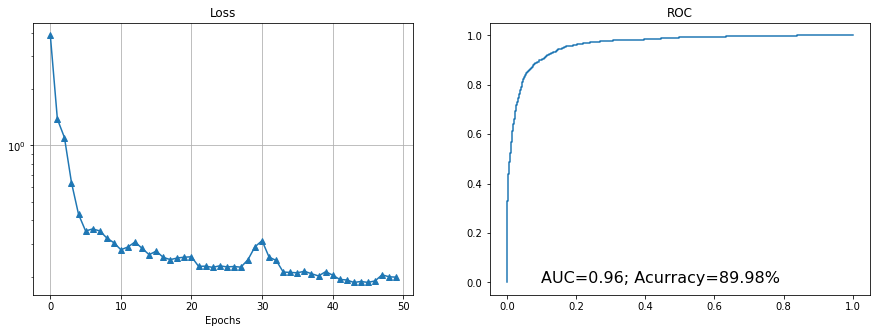

In [ ]:
resolutions = [30, 50, 70,100]
for res in resolutions:
    D = res * res * 3
    resized_train_images, resized_test_images = [], []
    beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
    for i in range(len(img_train)):
        resized_train_images.append(resize(img_train[i], (res * res * 3,)))
    for i in range(len(img_test)):
        resized_test_images.append(resize(img_test[i], (res * res * 3,)))
    img_train_resolution, y_train_resolution = np.array(resized_train_images), np.array(y_train)
    img_test_resolution, y_test_resolution = np.array(resized_test_images), np.array(y_test)
    print(f"--------------Image Resolution: {res} * {res}--------------")
    beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_resolution, y_train_resolution, img_test_resolution, y_test_resolution, beta_init, n_epoch, op_adam)
    #beta, loss_history_end_epoch = run_SGD(minibatch, img_train_resolution, y_train_resolution, img_test_resolution, y_test_resolution, beta_init, n_epoch)
    fpr,tpr,auc,accuracy = evaluate(beta, loss_history_end_epoch, img_test_resolution, y_test_resolution)
del resized_train_images, resized_test_images # reduce Disk/RAM usage

__TODO__: Test accuracy increases when images with higher resolution are used.

### Task 3. Image Preprocessing
#### 3.1 Changing Contrast

In [ ]:
img_train_contrast, img_test_contrast, y_train, y_test = get_data(np.arange(5000), np.arange(15000, 20000), (100,100), True, True, None)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

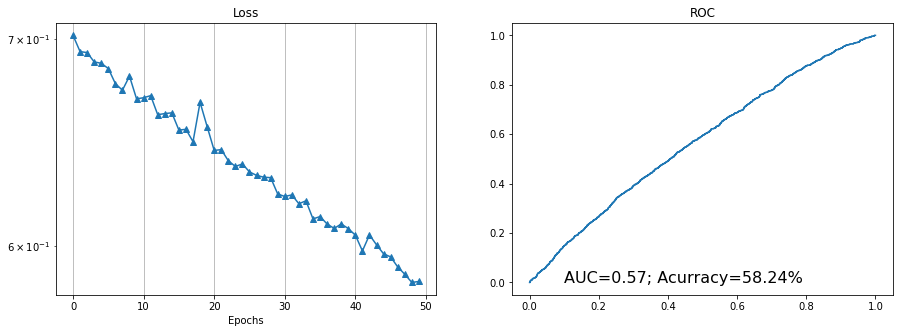

In [ ]:
# Initialise beta
D = 100*100*3
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
minibatch = 500
n_epoch = 50
#beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_contrast, y_train, img_test_contrast, y_test, beta_init, n_epoch, op_adam)
beta, loss_history_end_epoch = run_SGD(minibatch, img_train_contrast, y_train, img_test_contrast, y_test, beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_contrast, y_test)
del img_train_contrast, img_test_contrast # reduce Disk/RAM usage

__TODO__: Test accuracy gets worse with higher or lower contrast.

#### 3.2 Black & White vs Colored

In [ ]:
img_train_bw, img_test_bw, y_train, y_test = get_data(np.arange(5000), np.arange(15000, 20000), (100,100), False, True, None)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

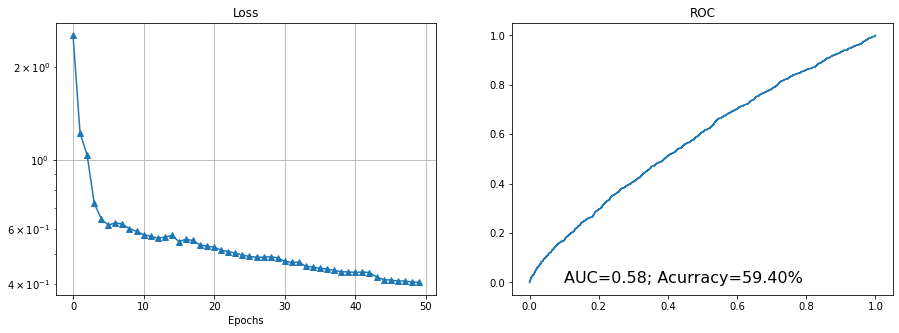

In [ ]:
beta_init = np.random.normal(0., scale = 1./np.sqrt(100*100), size=100*100)
minibatch = 500
n_epoch = 50
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_bw, y_train, img_test_bw, y_test, beta_init, n_epoch, op_adam)
#beta, loss_history_end_epoch = run_SGD(minibatch, img_train_bw, y_train, img_test_bw, y_test, beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_bw, y_test)
del img_train_bw, img_test_bw # reduce Disk/RAM usage

__TODO__: Colored images lead to a better performance for classifier than black and white images.

### Task 4. Image Cropping (Eye only)

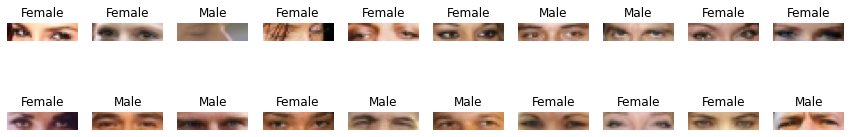

In [ ]:
# crop eye
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100 for display (you do not have to do this in the assignment)
    im = resize(im, (100,100) )
    im = im[45:55,30:70]
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    

In [ ]:
img_train_eye, img_test_eye, y_train,y_test = get_data(np.arange(5000), np.arange(15000, 20000), (100,100), True, False, (45,55,30,70))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
img_train_eye.shape

(5000, 1200)

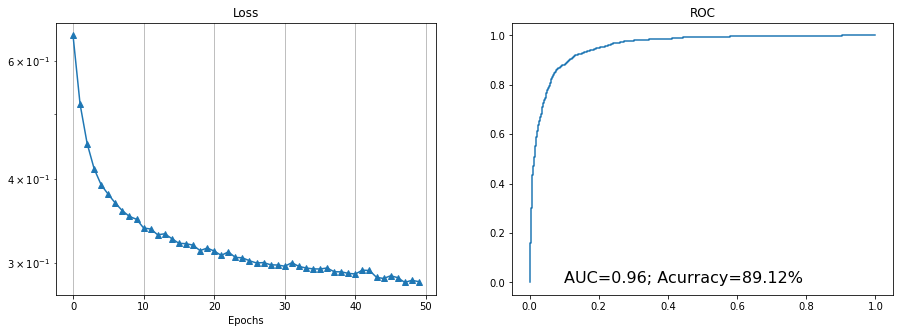

In [ ]:
minibatch = 500
n_epoch = 50
# Initialise beta
D = 1200
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_eye, y_train, img_test_eye, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_eye, y_train, img_test_eye, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_eye, y_test)

#### Task 5. Ensemble model

In [ ]:
 facial = {'eyes':(45,55,30,70), 'nose':(50,65,40,60), 'mouth':(65,75,35,65), 'chin':(75,85,40,60), 'forehead':(30,45,40,60), 'left_ear':(50,85,70,85), 'right_ear':(50,85,15,30)}
 facial_kwargs = {'train_indices':np.arange(5000), 'test_indices':np.arange(15000,20000), 'reshape_size':(100,100), 'is_color':True, 'contrast_adjust':False, 'batch_size':500, 'epochs':50}

In [ ]:
def run_ensemble(parts,**kwargs):
  beta_list = []
  train_pred_list = []
  test_pred_list = []
  for key,value in parts.items():
    print(key,":",value)
    img_train, img_test, y_train, y_test = get_data(train_indices=kwargs['train_indices'],test_indices=kwargs['test_indices'],reshape_size=kwargs['reshape_size'],is_color=kwargs['is_color'],contrast_adjust=kwargs['contrast_adjust'],cropping=value)
    D = (value[1]-value[0])*(value[3]-value[2])*3
    beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
    beta, loss_history_end_epoch = run_Optimizer(kwargs['batch_size'], img_train, y_train, img_test, y_test, beta_init, kwargs['epochs'],op_adam)
    beta_list.append(beta)

    pred_bool = prediction_batch(beta, img_train) > 0.5
    pred = 2*pred_bool - 1
    train_pred_list.append(pred)

    pred_bool = prediction_batch(beta, img_test) > 0.5
    pred = 2*pred_bool - 1
    test_pred_list.append(pred)

  beta_list = np.array(beta_list)
  train_pred_list = np.array(train_pred_list)
  test_pred_list = np.array(test_pred_list)

  return beta_list,train_pred_list,test_pred_list,y_train,y_test

def evaluate_ensemble(parts,train_pred_list,test_pred_list,y_train,y_test,plot=True):
  for i,key in enumerate(parts):
    print('{:15s}'.format(key),"train:",'{:.4f}'.format(np.mean(((train_pred_list[i]>0)*2-1) == y_train)),"\ttest:",'{:.4f}'.format(np.mean(((test_pred_list[i]>0)*2-1) == y_test)))
  print('-'*50)
  print('{:15s}'.format('ensemble'),"train:",'{:.4f}'.format(np.mean(((np.mean(train_pred_list,axis=0)>0)*2-1)==y_train)),"\ttest:",'{:.4f}'.format(np.mean(((np.mean(test_pred_list,axis=0)>0)*2-1)==y_test)))

  if plot:
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    sns.histplot([np.sum(y_train[i]==train_pred_list[:,i]) for i in range(len(y_train))],discrete=True,stat='proportion')
    plt.title("Train")
    plt.xlabel("No. of correct models")
    ax2 = plt.subplot(1,2,2,sharey=ax1)
    sns.histplot([np.sum(y_test[i]==test_pred_list[:,i]) for i in range(len(y_test))],discrete=True,stat='proportion')
    plt.title("Test")
    plt.xlabel("No. of correct models")

  return 

In [ ]:
facial_beta,facial_train_pred,facial_test_pred,facial_y_train,facial_y_test = run_ensemble(facial,**facial_kwargs)

eyes : (45, 55, 30, 70)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

nose : (50, 65, 40, 60)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

mouth : (65, 75, 35, 65)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

chin : (75, 85, 40, 60)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

forehead : (30, 45, 40, 60)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

left_ear : (50, 85, 70, 85)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

right_ear : (50, 85, 15, 30)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


eyes            train: 0.8926 	test: 0.8954
nose            train: 0.8102 	test: 0.8040
mouth           train: 0.7472 	test: 0.7392
chin            train: 0.7106 	test: 0.7064
forehead        train: 0.6290 	test: 0.6322
left_ear        train: 0.6932 	test: 0.6824
right_ear       train: 0.6990 	test: 0.6812
--------------------------------------------------
ensemble        train: 0.8266 	test: 0.8232


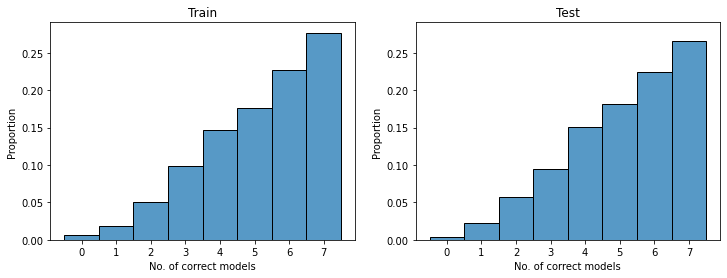

In [ ]:
evaluate_ensemble(facial,facial_train_pred,facial_test_pred,facial_y_train,facial_y_test)

In [ ]:
reshape_size = (100,100)
rows, cols = 3, 3
win_height, win_width = int(np.ceil(reshape_size[0]/rows)),int(np.ceil(reshape_size[1]/cols))
windows = [(win_height*i,min(win_height*(i+1),reshape_size[0]),win_width*j,min(win_width*(j+1),reshape_size[1])) for i in range(rows) for j in range(cols)]
windows = dict(zip(['window #'+str(i) for i in range(rows*cols)],windows))

In [ ]:
windows

{'window #0': (0, 34, 0, 34),
 'window #1': (0, 34, 34, 68),
 'window #2': (0, 34, 68, 100),
 'window #3': (34, 68, 0, 34),
 'window #4': (34, 68, 34, 68),
 'window #5': (34, 68, 68, 100),
 'window #6': (68, 100, 0, 34),
 'window #7': (68, 100, 34, 68),
 'window #8': (68, 100, 68, 100)}

In [ ]:
unif_win_beta,unif_win_train_pred,unif_win_test_pred,unif_win_y_train,unif_win_y_test = run_ensemble(windows,**facial_kwargs)

window #0 : (0, 34, 0, 34)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #1 : (0, 34, 34, 68)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #2 : (0, 34, 68, 100)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #3 : (34, 68, 0, 34)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #4 : (34, 68, 34, 68)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #5 : (34, 68, 68, 100)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #6 : (68, 100, 0, 34)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #7 : (68, 100, 34, 68)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

window #8 : (68, 100, 68, 100)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


window #0       train: 0.6386 	test: 0.6218
window #1       train: 0.6734 	test: 0.6488
window #2       train: 0.6344 	test: 0.6184
window #3       train: 0.7632 	test: 0.7486
window #4       train: 0.9052 	test: 0.9054
window #5       train: 0.7146 	test: 0.6932
window #6       train: 0.7512 	test: 0.7304
window #7       train: 0.7918 	test: 0.7730
window #8       train: 0.7472 	test: 0.7296
--------------------------------------------------
ensemble        train: 0.8224 	test: 0.8054


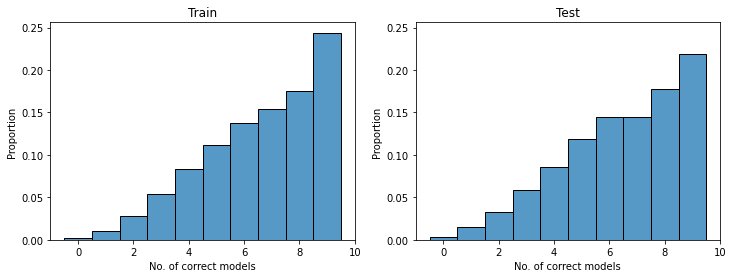

In [ ]:
evaluate_ensemble(windows,unif_win_train_pred,unif_win_test_pred,unif_win_y_train,unif_win_y_test)

### Task 7. First_200_training
Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).

##### Face(First 200 images training data)

In [ ]:
img_train_200, img_test, y_train_200, y_test = get_data(np.arange(200), np.arange(15000, 20000), (100,100), True, False, None)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

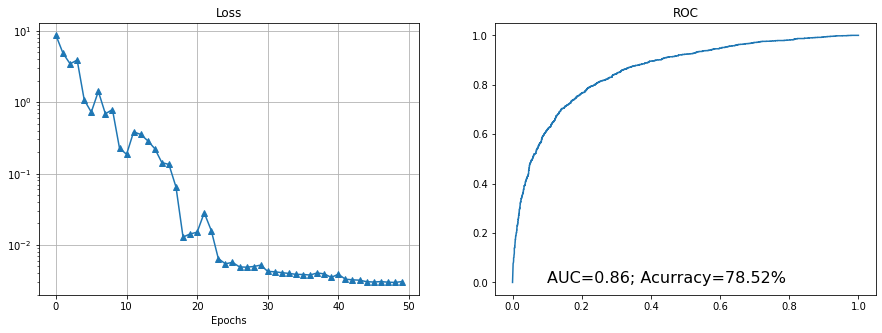

In [ ]:
minibatch = 10
n_epoch = 50
beta_init = np.random.normal(0., scale = 1./np.sqrt(100*100*3), size=100*100*3)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_200,y_train_200, img_test, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_200, y_train_200, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

##### Eye only (First 200 images training data)

In [ ]:
img_train_200_eye=img_train_eye[:200] #img_test_eye, y_train,y_test

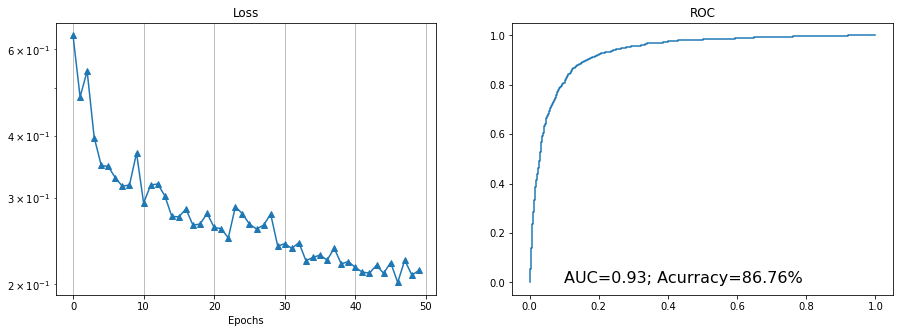

In [ ]:
minibatch =10
n_epoch = 50
D=1200
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_200_eye,y_train_200, img_test_eye, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_200, y_train_200, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_eye, y_test)

#### Data Augmentation

In [ ]:
!pip install imgaug

In [ ]:
import imgaug.augmenters as iaa
import cv2

#### Images Augmentation- Gaussian Noise & Contrast normalization

In [ ]:
seq = iaa.Sequential(
    [     
        iaa.ContrastNormalization((0.75, 1.5)),
        #iaa.AddToHueAndSaturation((40, 50))
        iaa.AdditiveGaussianNoise(scale=(5, 20))    
    ],random_order=True)  # apply augmenters in random order

In [ ]:
images_aug=[]
for k in range(20):
  #load image
  img =imageio.imread(os.path.join(path, all_img[k]))
  #img = cv2.imread(os.path.join(path, all_img[k]))
  images_aug.append(img)

In [ ]:
augmented_images = seq(images=images_aug)

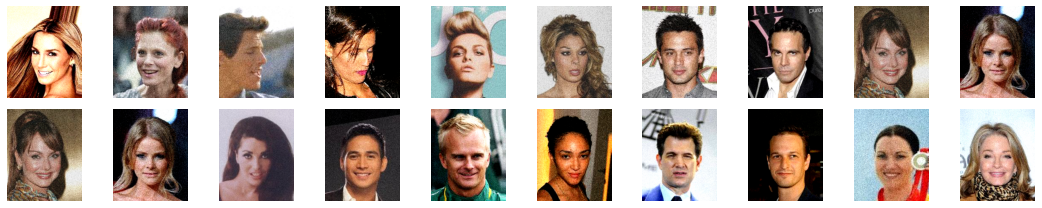

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(15,3))
for i in range(2):
    for j in range(10):
        k = i*8 + j
        axes[i][j].imshow(augmented_images[k]/255.)
        axes[i][j].axis('off')
fig.tight_layout()

In [ ]:
# Image augmentation
aug=[]
for i in range(200):
  img = imageio.imread(os.path.join(path, all_img[i]))
  #hue=iaa.AddToHueAndSaturation((40,50))
  noise=iaa.AdditiveGaussianNoise(scale=(5,20))
  aug_img=noise(images=img)
  aug_img=resize(aug_img, (100,100))
  aug_img=aug_img.reshape(100*100*3)
  aug.append(aug_img)
for i in range(200):
  img = imageio.imread(os.path.join(path, all_img[i]))
  contrast=iaa.ContrastNormalization((0.75,1.5))
  aug_img=contrast(images=img)
  aug_img = resize(aug_img, (100,100))
  aug_img=aug_img.reshape(100*100*3)
  aug.append(aug_img)
#aug = np.array(aug, dtype="float") / 255.0

In [ ]:
img_train_aug = np.vstack([img_train_200, aug])
y_train_aug=np.hstack([y_train_200,y_train_200,y_train_200])

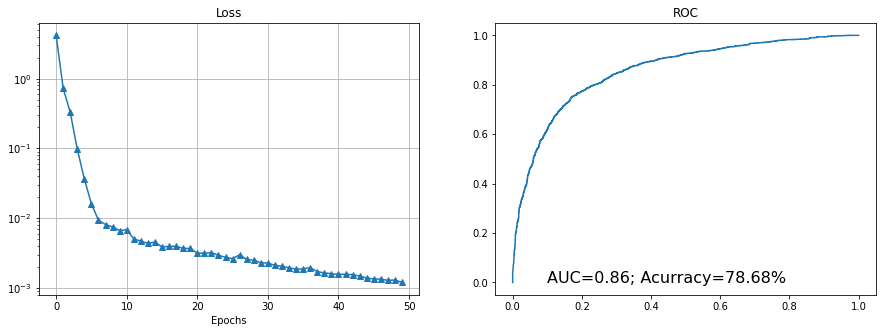

In [ ]:
minibatch =10
n_epoch = 50
beta_init = np.random.normal(0., scale = 1./np.sqrt(100*100*3), size=100*100*3)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_aug,y_train_aug, img_test, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_aug, y_train_aug, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

##### Eye only (First 200 images training data)

In [ ]:
# Image augmentation
aug_eye=[]
for i in range(200):
  img = imageio.imread(os.path.join(path, all_img[i]))
  noise=iaa.AdditiveGaussianNoise(scale=(5, 20))
  aug_img=noise(images=img)
  aug_img=resize(aug_img, (100,100))
  aug_img = aug_img[45:55,30:70,:]
  aug_img=aug_img.reshape(1200)
  aug_eye.append(aug_img)
for i in range(200):
  img = imageio.imread(os.path.join(path, all_img[i]))
  contrast=iaa.ContrastNormalization((0.75, 1.5))
  aug_img=contrast(images=img)
  aug_img = resize(aug_img, (100,100))
  aug_img = aug_img[45:55,30:70,:]
  aug_img=aug_img.reshape(1200)
  aug_eye.append(aug_img)
#aug = np.array(aug, dtype="float") / 255.0

In [ ]:
img_train_aug_eye = np.vstack([img_train_200_eye, aug_eye])

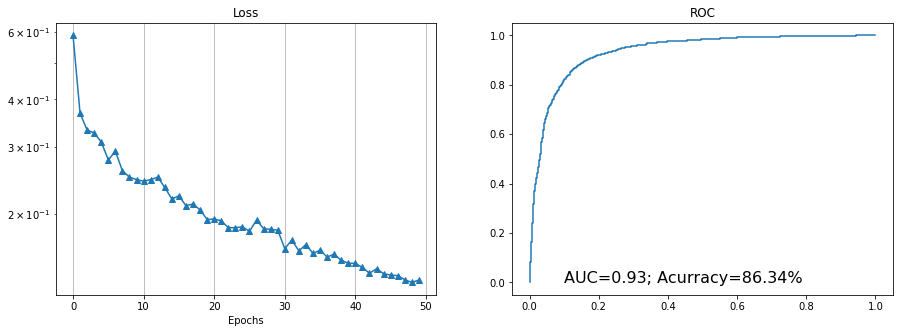

In [ ]:
minibatch =10
n_epoch = 50
D=1200
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_aug_eye,y_train_aug, img_test_eye, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_aug, y_train_aug, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_eye, y_test)

#### Regularization

* Logistic regression loss function with L2 penalty:
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{\lambda}{N} \| \beta \|^2$$

* Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

In [ ]:

@jax.jit ##Ridge 
def loss(beta, X, Y):

    # compute all the individual losses
    loss_individuals = loss_all(beta, X, Y)
    
    # return the average loss
    return jnp.mean(loss_individuals) + reg*jnp.mean((beta)**2)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))



--------------lambdas of regulation:0--------------


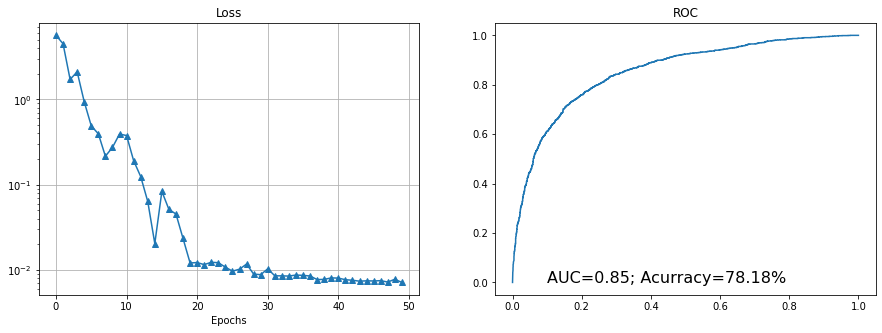

--------------lambdas of regulation:0.25--------------


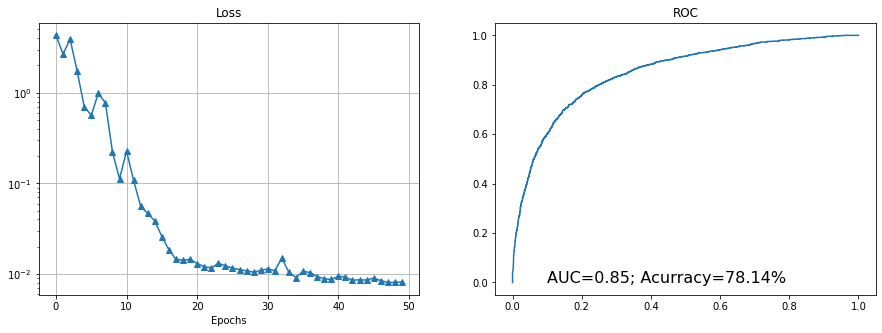

--------------lambdas of regulation:0.5--------------


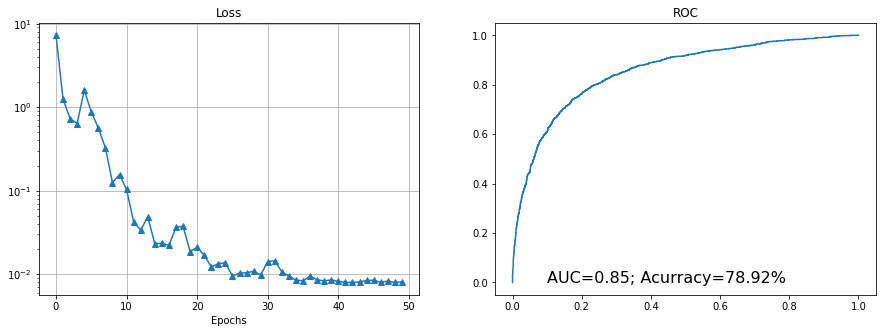

--------------lambdas of regulation:2--------------


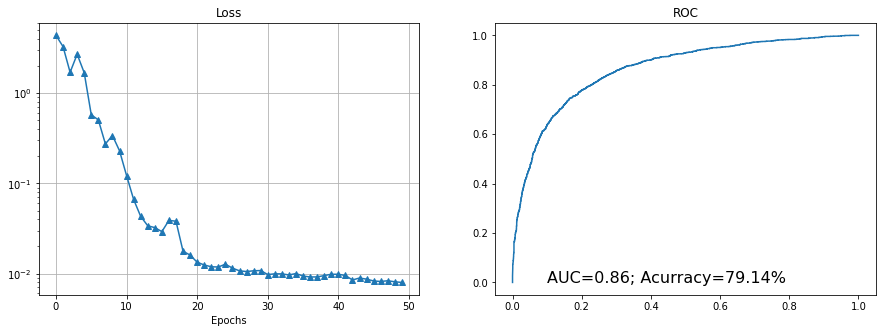

--------------lambdas of regulation:5--------------


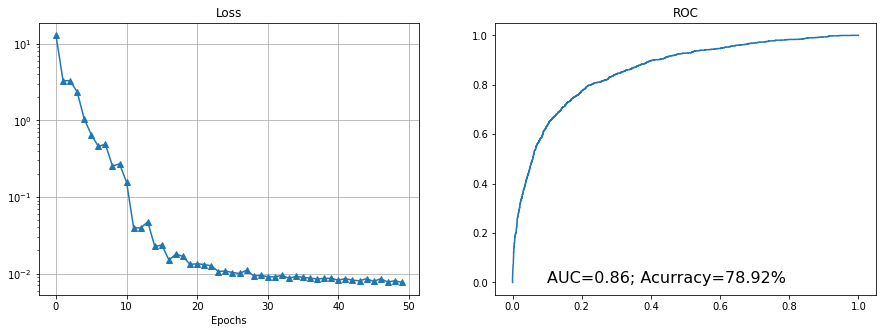

--------------lambdas of regulation:10--------------


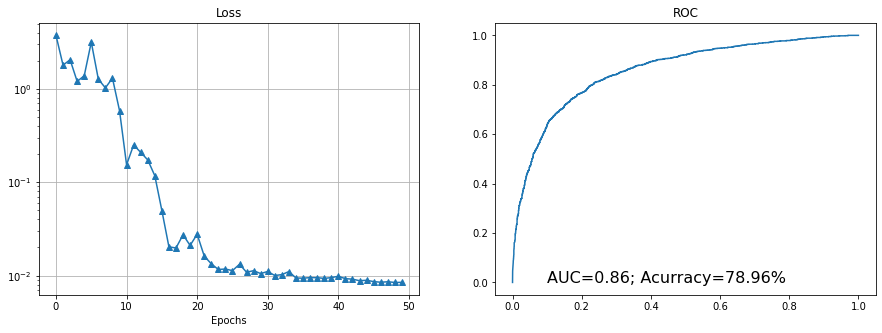

In [ ]:
regs = [0,0.25,0.5,2,5,10] # lambdas to test #
D = 100*100*3
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
for i in regs:
  print(f"--------------lambdas of regulation:{i}--------------")
  reg=i
  beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_200,y_train_200, img_test, y_test, beta_init, n_epoch, op_adam)
  #beta,loss_history_end_epoch = run_SGD(minibatch, img_train_200, y_train_200, img_test, y_test,beta_init, n_epoch)
  fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

##### Eye only (First 200 images training data)

--------------lambdas of regulation:0--------------


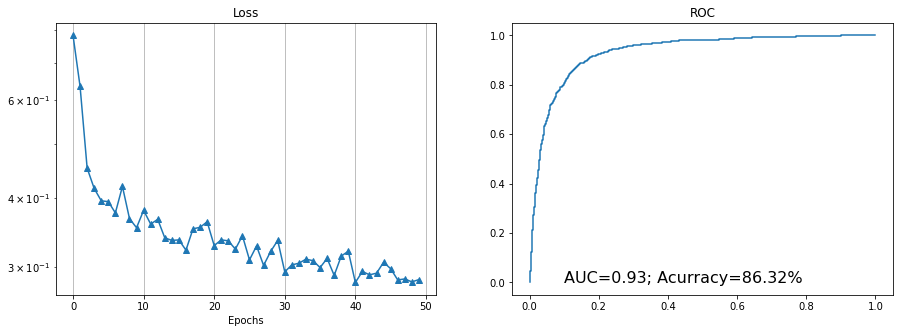

--------------lambdas of regulation:0.25--------------


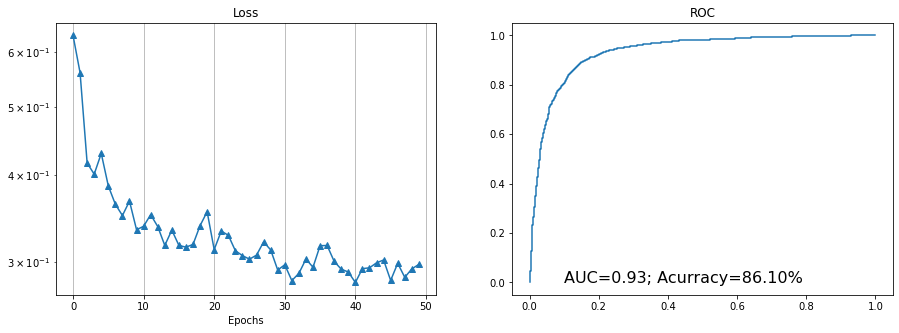

--------------lambdas of regulation:0.5--------------


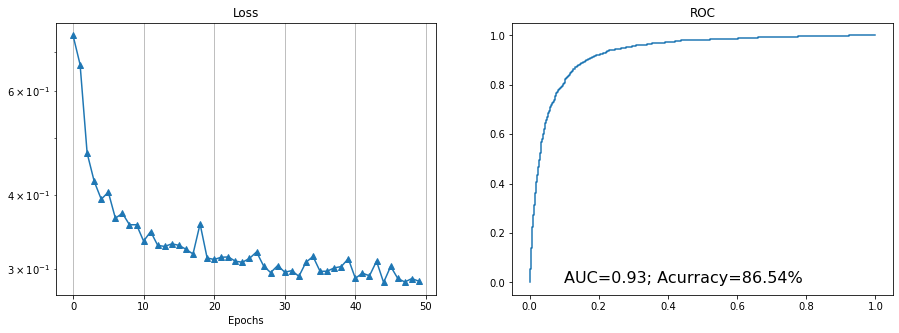

--------------lambdas of regulation:2--------------


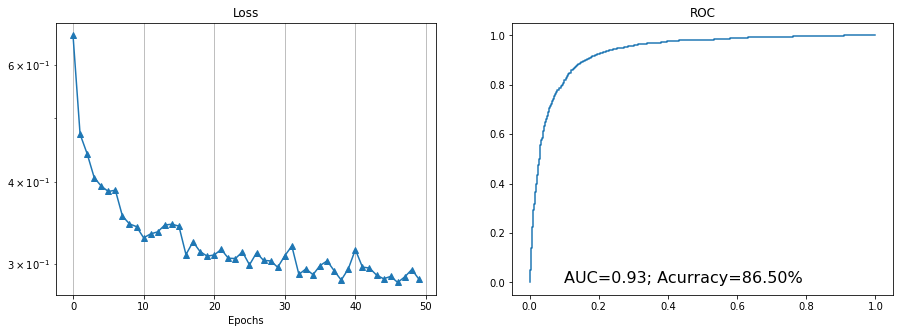

--------------lambdas of regulation:5--------------


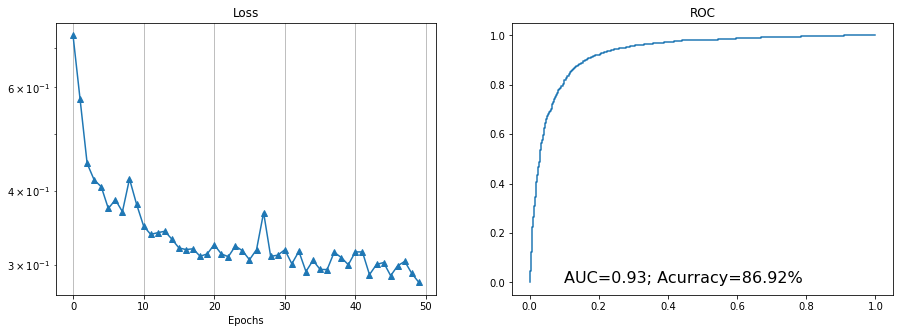

--------------lambdas of regulation:10--------------


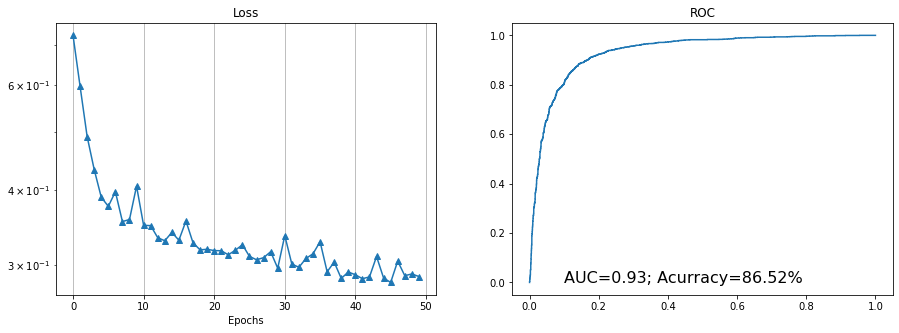

In [ ]:
regs = [0,0.25,0.5,2,5,10] # lambdas to test #
D = 1200
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
loss_history_end_epoch = []
for i in regs:
  print(f"--------------lambdas of regulation:{i}--------------")
  reg=i
  beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_200_eye,y_train_200, img_test_eye, y_test, beta_init, n_epoch, op_adam)
  #beta,loss_history_end_epoch = run_SGD(minibatch, img_train_200, y_train_200, img_test, y_test,beta_init, n_epoch)
  fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_eye, y_test)

#### Regularization with data augmentation

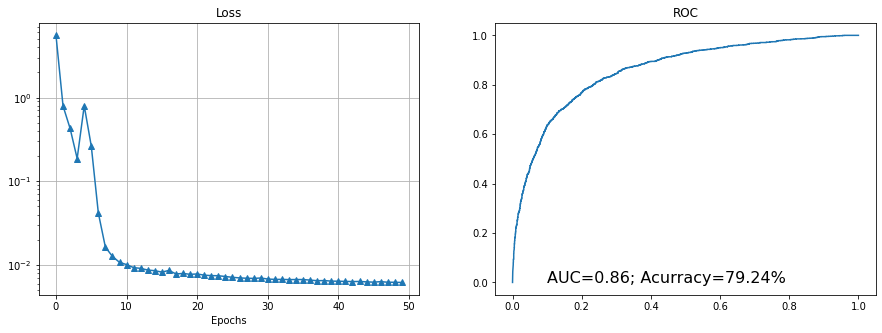

In [ ]:
regs = 0.25 # lambdas to test
D = 100*100*3
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
minibatch =10
n_epoch = 50
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_aug,y_train_aug, img_test, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_aug, y_train_aug, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test, y_test)

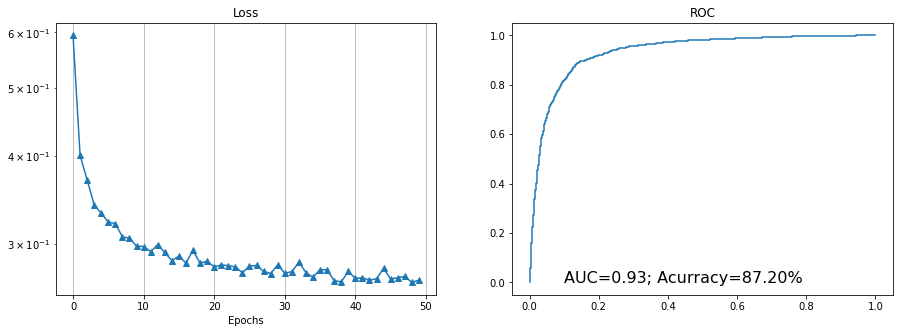

In [ ]:
regs = 0.25 # lambdas to test
minibatch =10
n_epoch = 50
D=1200
beta_init = np.random.normal(0., scale = 1./np.sqrt(D), size=D)
beta,loss_history_end_epoch = run_Optimizer(minibatch, img_train_aug_eye,y_train_aug, img_test_eye, y_test, beta_init, n_epoch, op_adam)
#beta,loss_history_end_epoch = run_SGD(minibatch, img_train_aug, y_train_aug, img_test, y_test,beta_init, n_epoch)
fpr, tpr, auc, accuracy = evaluate(beta, loss_history_end_epoch, img_test_eye, y_test)

In [ ]:
@jax.jit
def loss(beta, X, Y):
    # compute all the individual losses
    loss_individuals = loss_all(beta, X, Y)
    # return the average loss
    return jnp.mean(loss_individuals)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))